Do some Clustering of phenotypic data
- get pheno stuff as a matrix
- take the distance/1-correlation matrix of that
- cluster with scipy cluster
- happiness

In [119]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from scipy import cluster as scl
from scipy import stats, integrate
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn.apionly as sns
import itertools
from nilearn import plotting as nplt

In [85]:
%load_ext oct2py.ipython

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [86]:
def space_mat(mat, cuts):
    # Currently can only handle 2 dim
    if not len(mat.shape)==2:
        raise Exception('Get that non twodimensional shit out of here!')
    
    cutpos = np.array([i[0] for i in cuts])
    # Make sure all positions are unique
    if not len(np.unique(cutpos))==len(cutpos):
        # Deal with the duplicates and non-duplicates separately
        spread = np.array([i[1] for i in cuts])
        # Find Duplicates
        v, c = np.unique(cutpos, return_counts=True)
        duplicates = v[c>1]
        # Get the non-duplicates
        non_dupl = [i for i in cuts if not i[0] in duplicates]
        # Set the spread to max of the duplicates
        dupl = list()
        for dup in duplicates:
            # Get index of other duplicates
            dind = np.argwhere(cutpos==dup)
            maxspread = np.max(spread[dind])
            dupl.append((dup, maxspread))
        # Combine the two lists
        cuts = non_dupl + dupl
        print('I found duplicates and took the biggest spread.')
        
    cutpos = np.array([i[0] for i in cuts])
    # Sort the positions in case they aren't already
    cutorder = np.argsort(cutpos)
    cutord = cutpos[cutorder]
    cutpad = np.array([i[1] for i in cuts])[cutorder]
    # Get the amount of total padding
    n_pad = np.sum(cutpad)
    # Create the output matrix
    vmat = np.zeros((mat.shape[0], mat.shape[1]+n_pad))
    omat = np.zeros([i+n_pad for i in mat.shape])
    invmat = np.zeros([i+n_pad for i in mat.shape])
    clustmat = np.zeros([i+n_pad for i in mat.shape])
    
    # Do this vertically first
    padsum = 0
    for cid, cut in enumerate(cutpos):
        if cid == 0:
            vmat[:, :cutord[cid]] = mat[:, :cutord[cid]]
            padsum = cutpad[cid]
        else:
            vmat[:, cutord[cid-1]+padsum:cutord[cid]+padsum] = mat[:, cutord[cid-1]:cutord[cid]]
            padsum += cutpad[cid]
            
    vmat[:, cutord[cid]+padsum:] = mat[:, cutord[cid]:]
    
    # Do this horizontally now and for the inverse matrix
    padsum = 0
    lastpos = 0
    for cid, cut in enumerate(cutpos):
        invmat[cutord[cid]+padsum:cutord[cid]+cutpad[cid]+padsum, :] = 1
        invmat[:, cutord[cid]+padsum:cutord[cid]+cutpad[cid]+padsum] = 1
        
        if cid == 0:
            omat[:cutord[cid], :] = vmat[:cutord[cid], :]
            
            select = tuple(np.arange(cutord[cid], cutord[cid]+cutpad[cid]+1))
            # Columns
            clustmat[:cutord[cid]+padsum+cutpad[cid], select] = cid+1
            # Rows
            clustmat[select, :cutord[cid]+padsum+cutpad[cid]] = cid+1
            
            padsum = cutpad[cid]
            lastpos = cutord[cid] + padsum
            
        else:
            omat[cutord[cid-1]+padsum:cutord[cid]+padsum, :] = vmat[cutord[cid-1]:cutord[cid], :]
            select_f = tuple(np.arange(cutord[cid-1]+padsum-cutpad[cid-1], cutord[cid-1]+padsum))
            select_b = tuple(np.arange(cutord[cid]+padsum, cutord[cid]+padsum+cutpad[cid]))
            select = select_f + select_b
            # Columns
            clustmat[lastpos:cutord[cid]+padsum+cutpad[cid], select] = cid+1
            # Rows
            clustmat[select, lastpos:cutord[cid]+padsum+cutpad[cid]] = cid+1
            
            padsum += cutpad[cid]
            lastpos = cutord[cid] + padsum

    omat[cutord[cid]+padsum:, :] = vmat[cutord[cid]:, :]
    # Add last cluster
    # TODO: make this less hacky, only works if 
    # last cluster was also the last before bottom right
    clustmat[lastpos:, select_b] = cid+2
    clustmat[select_b, lastpos:] = cid+2
    
    return omat, invmat, clustmat, cuts

In [87]:
def fix_ticks(n_elements, cuts, pad):
    '''
    Function to compute the new tick positions.
    
    n_elements are the number of elements in the original data
    (original_data.shape[0])
    cuts is the list of breakpoints
    pad is the number of empty voxels added after each breakpoint
    '''
    breaks = np.array([c[0] for c in cuts])

    l = []
    run = -1
    for i in np.arange(n_elements):
        if not i in breaks:
            run += 1
            l.append(run)
        else:
            run += 1+pad
            l.append(run)
    return l

In [88]:
def breakcords(cuts, shape):
    breaks = np.array([c[0] for c in cuts])
    pads = np.array([p[1] for p in cuts])
    
    tmp = [[cid]*(pads[np.argwhere(breaks==cid)][0][0]+1) if cid in breaks else [cid] for cid in np.arange(shape[0])]
    remap = np.array([coord for subl in tmp for coord in subl])
    
    return remap

In [89]:
def make_mask(shape, cuts, remap, start, stop):
    mask = np.zeros(shape)
    order = np.argsort([i[0] for i in cuts])
    sort_cut = np.array(cuts)[order][:, 0]
    mk = np.zeros_like(remap, dtype=bool)
    
    for cid, cut in enumerate(sort_cut):
        mk = np.zeros_like(remap, dtype=bool)
        # Drop last voxel in remap (no idea why that's there)
        mk[np.where(remap==cut)[0][:-1]] = True
        
        rm_cut = np.argwhere(mk)
        if cid==0:
            mask[mk, start:np.max(rm_cut)] = cid+1
            mask[start:np.max(rm_cut), mk] = cid+1
        else:
            cut_back = sort_cut[cid-1]
            mk_b = np.zeros_like(remap, dtype=bool)
            mk_b[np.where(remap==cut_back)[0][:-1]] = True
            rm_cut_back = np.argwhere(mk_b)
            
            # Drop last voxel in remap (no idea why that's there)
            mk_b[np.where(remap==cut_back)[0][:-1]] = True
            # Row
            mask[mk|mk_b, np.min(rm_cut_back):np.max(rm_cut)] = cid+1
            # Column
            mask[np.min(rm_cut_back):np.max(rm_cut), mk|mk_b] = cid+1
    # Last thing
    mask[mk, np.min(rm_cut):stop] = cid+2
    mask[np.min(rm_cut):stop, mk] = cid+2
            
    out_mask = np.ma.masked_where(mask==0, mask)
    return out_mask

In [90]:
# Load pheno file
#path_root = '/media/yassinebha/database29/Drive/HCP/'
path_root = '/home/yassinebha/Drive/HCP/'
pheno = pd.read_csv(os.path.join(path_root,'subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean.csv'))
use_columns = pheno.drop(["Subject",
                          "Zygosity",
                          'Age_in_Yrs',
                          'Gender',
                          'Race',
                          'Ethnicity',
                          'SSAGA_Income',
                          'SSAGA_Educ',
                          'Endurance_Unadj'                        
                         ], axis=1).columns.get_values() # here all pheno
# Number of subtypes
n_sbt = 9
sbt_pheno = pheno[use_columns]
# Find guys who are missing any of these columns
missing = np.array([sbt_pheno[col].isnull().values for col in use_columns]).any(0)
# Don't use these guys
use_pheno = sbt_pheno[~missing]
#save_pheno = use_pheno
use_pheno.to_csv(os.path.join(path_root,'subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan.csv'), index=False)

In [91]:
# Show list of columns
list(use_pheno.columns)

['Handedness',
 'BMI',
 'BPSystolic',
 'BPDiastolic',
 'PSQI_Score',
 'PicSeq_Unadj',
 'CardSort_Unadj',
 'Flanker_Unadj',
 'PMAT24_A_CR',
 'PMAT24_A_RTCR',
 'ReadEng_Unadj',
 'PicVocab_Unadj',
 'ProcSpeed_Unadj',
 'DDisc_AUC_200',
 'DDisc_AUC_40K',
 'VSPLOT_TC',
 'VSPLOT_CRTE',
 'SCPT_TP',
 'SCPT_TN',
 'SCPT_TPRT',
 'IWRD_TOT',
 'IWRD_RTC',
 'ER40_CR',
 'ER40_CRT',
 'Sadness_Unadj',
 'FearSomat_Unadj',
 'FearAffect_Unadj',
 'AngAggr_Unadj',
 'AngHostil_Unadj',
 'AngAffect_Unadj',
 'LifeSatisf_Unadj',
 'MeanPurp_Unadj',
 'PosAffect_Unadj',
 'Friendship_Unadj',
 'Loneliness_Unadj',
 'PercHostil_Unadj',
 'PercReject_Unadj',
 'EmotSupp_Unadj',
 'InstruSupp_Unadj',
 'PercStress_Unadj',
 'SelfEff_Unadj',
 'PainInterf_Tscore',
 'Taste_Unadj',
 'Dexterity_Unadj',
 'Strength_Unadj',
 'NEOFAC_A',
 'NEOFAC_O',
 'NEOFAC_C',
 'NEOFAC_N',
 'NEOFAC_E',
 'ASR_Anxd_Pct',
 'ASR_Witd_Pct',
 'ASR_Soma_Pct',
 'ASR_Thot_Pct',
 'ASR_Attn_Pct',
 'ASR_Aggr_Pct',
 'ASR_Rule_Pct',
 'ASR_Intr_Pct',
 'ASR_Intn_T'

In [92]:
# Make matrix out of the remaining guys except subject ID column
pheno_mat = use_pheno.as_matrix()
# Normalize these guys by column
pheno_norm = (pheno_mat - np.mean(pheno_mat, 0))/np.std(pheno_mat, 0)

In [93]:
# Save normalized pheno to be used in octave for bootsrap analysis
ind = use_pheno.index
pheno_norm_df = pd.DataFrame(pheno_norm, columns=use_pheno.columns.get_values(),index=ind)
# merge back ID
merged_pheno_norm = pd.merge(pheno[["Subject"]], pheno_norm_df, how='right', left_index=True, right_index=True)
merged_pheno_norm.rename(columns = {'Subject':''}).to_csv(os.path.join(path_root,'subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv'), index=False)

In [94]:
merged_pheno_norm.head()

,Subject,Handedness,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,100004,0.654367,-0.262795,0.706508,-0.038133,0.912634,0.543120,-1.133786,0.964184,0.526831,...,-0.560257,-0.137093,0.904230,0.582300,0.871791,-0.430821,-0.682838,1.605890,-0.312732,1.863197
1,100206,-0.008896,-0.057218,-0.392537,-0.584901,0.249934,1.010833,0.415954,1.810203,0.732102,...,0.600528,1.133355,2.036441,1.148677,2.255963,1.506107,2.573747,2.101592,1.602519,0.819628
2,100307,0.654367,-0.715064,-0.529918,-0.676029,-0.744115,-0.050883,0.863311,0.022050,0.116291,...,-0.560257,-0.681571,-0.888437,-0.323905,-0.685403,-0.624514,-0.682838,-0.707386,-0.660960,-0.432656
3,100408,-0.229983,0.141209,1.874244,1.511043,-0.081415,1.057825,-0.360372,0.885089,-1.936414,...,0.407063,-0.681571,-0.982788,-0.210629,-0.685403,-0.430821,-0.682838,-0.707386,-0.660960,-0.432656
4,100610,0.433279,1.778676,1.118650,-0.220389,-0.081415,-0.166160,1.454289,1.420734,1.347913,...,-0.753721,-0.137093,0.432475,-0.323905,-0.685403,-0.624514,-0.682838,2.597294,-0.835073,-0.641370


In [95]:
# Get the correlation of these
pheno_corr = np.corrcoef(pheno_norm.T)
# And get the distance matrix of that
pheno_dist = scl.hierarchy.distance.pdist(pheno_norm.T)
pheno_dist_mat = scl.hierarchy.distance.squareform(pheno_dist)

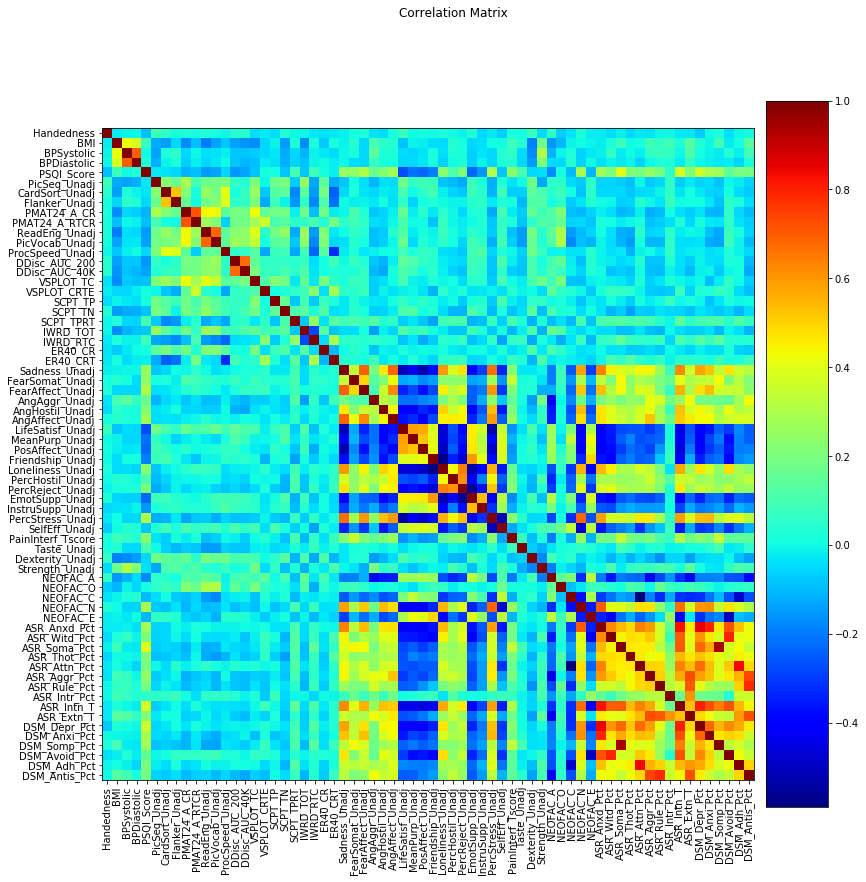

In [96]:
# Show that correlation
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(pheno_corr,cmap = mpl.cm.jet)
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(use_columns)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(use_columns, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Correlation Matrix')

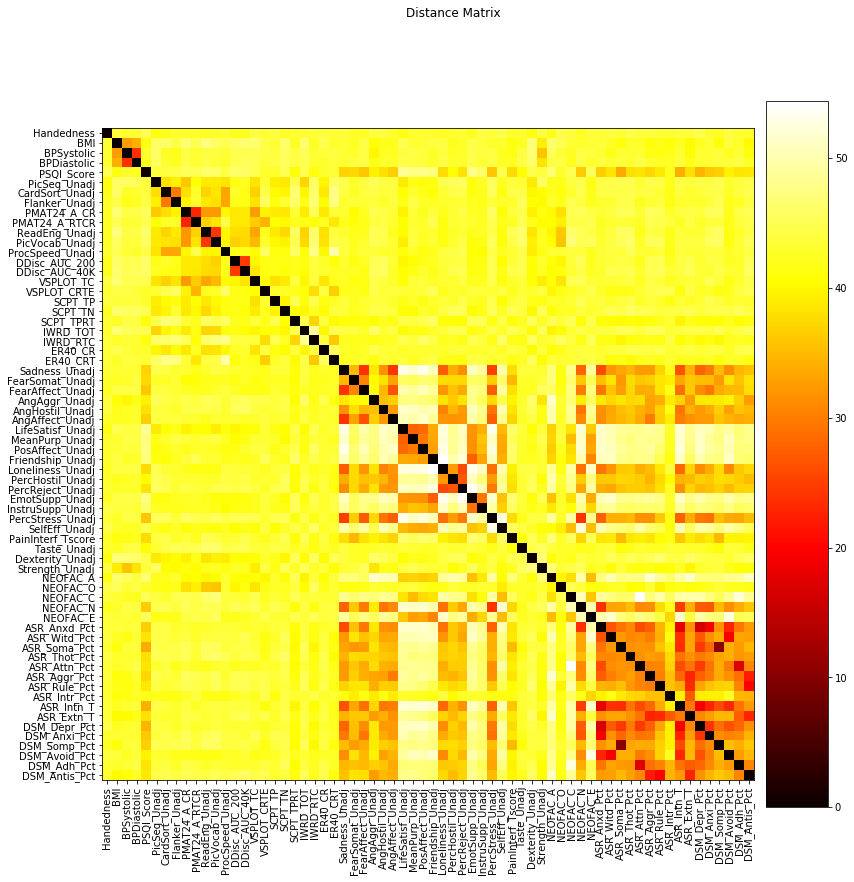

In [97]:
# Show that distance
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(pheno_dist_mat,cmap = mpl.cm.hot)
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(use_columns)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(use_columns, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Distance Matrix')

In [98]:
# Now do some clustering on that
n_sbt = 9 # Number of subtypesimport warnings
link = scl.hierarchy.linkage(pheno_dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

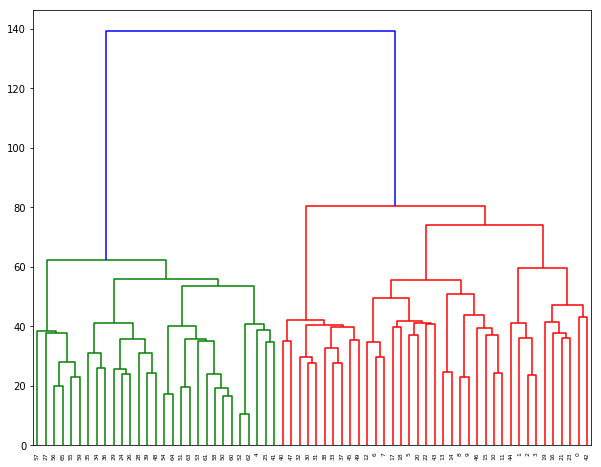

In [99]:
plt.figure(figsize=(10, 8))
dn = scl.hierarchy.dendrogram(link)

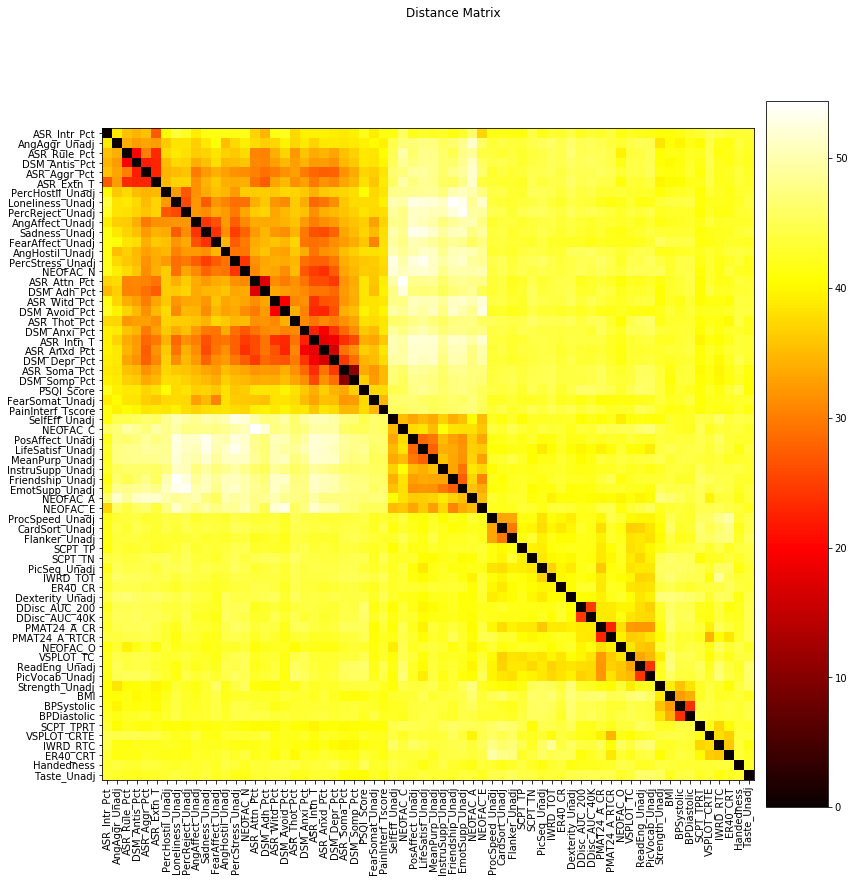

In [100]:
# Plot the distance matrix again, but now ordered by hierarchy
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(pheno_dist_mat[order, :][:, order],cmap =mpl.cm.hot)
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Distance Matrix')

In [77]:
t_clust = pheno_corr[order, :][:, order]
t_clust.shape

(66, 66)

In [116]:
n = len(part)
oci = order
pco = part[oci]

In [154]:
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]
#cuts = [(10,20)]

In [155]:
s9_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e",
             "#717833"]
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                          colors = s9_colors,
                                          N=n_sbt)

In [156]:
def make_boxes(mat, cl_def, pad=1):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        if not start<=0:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0]:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [157]:
mat, cmat, lmat, ind = make_boxes(t_clust, cuts, 1)

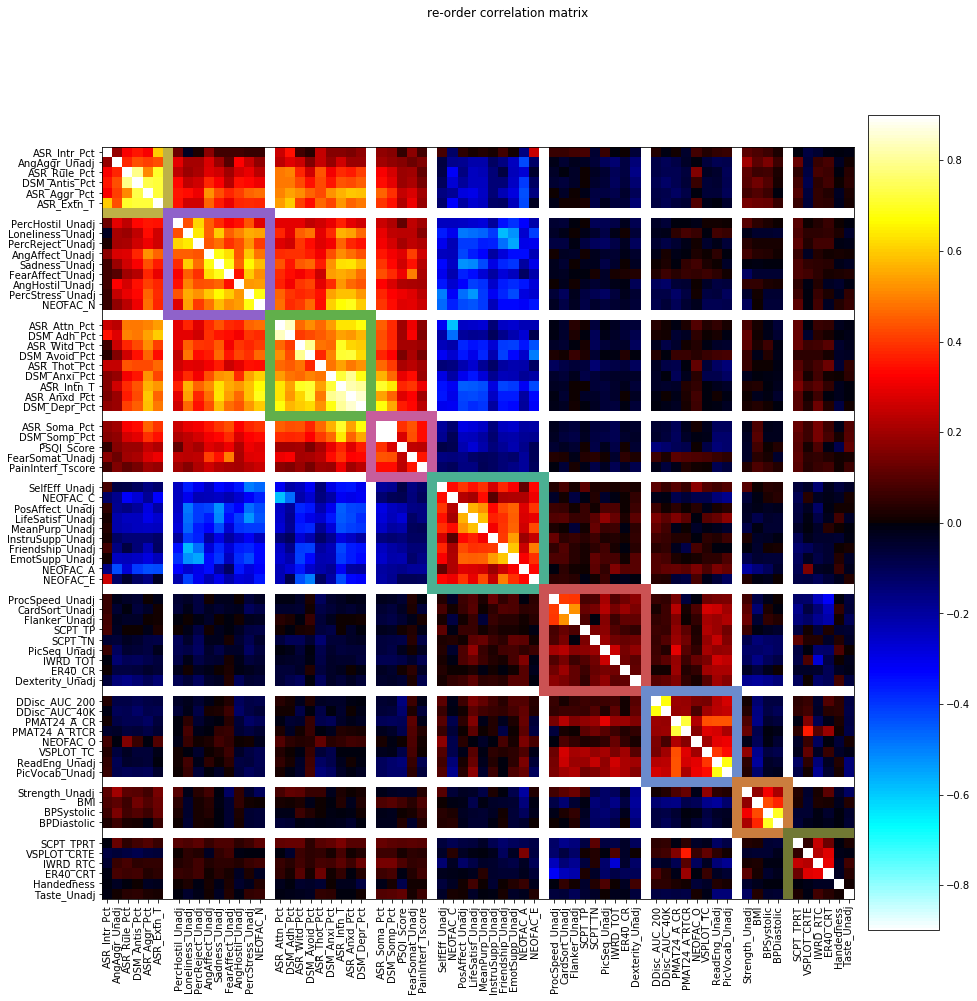

In [158]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat, cmap=nplt.cm.cold_hot, vmin=-0.9, vmax=0.9)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1)
tmp = ax.imshow(cmat, cmap=lin9)
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)

tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-order correlation matrix')
f.savefig('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/Figures/associations/pheno_clustered.svg')

In [144]:
# Here are the groups I found:
for sid in np.unique(part):
    match_cols = [use_columns[x] for x in np.where(part==sid)[0]]
    print('Subtype {} has the following variables:'.format(sid))
    for col in match_cols:
        print('    {}'.format(col))5360 8886 8984 9587

SyntaxError: invalid syntax (<ipython-input-144-043078e9e5cc>, line 6)

In [36]:
np.where(part==sid)[0]]],1)

array([ 0, 16, 19, 21, 23, 42])

In [26]:
sid

9

In [31]:
%%octave -s 600,800 -f svg -o fig
fig = figure
plot([1, 2, 3]);

fig =  1

In [33]:
type(fig)

float

In [37]:
# Make a new pheno table with the average scores of these subtypes
data = np.array([np.mean(pheno_norm_df[[use_columns[x] for x in np.where(part==sid)[0]]],1) for sid in np.unique(part)])
ind = pheno_norm_df.index
col_names = ['Subtype_{}'.format(x) for x in np.unique(part)]
sbt_pheno = pd.DataFrame(data=data.T, columns=col_names, index=ind)
# Merge this with the original dataframe so I can get all that other stuff I didn't use
merged_pheno = pd.merge(pheno, sbt_pheno, how='right', left_index=True, right_index=True)

In [38]:
# Look at it (new stuff on the right)
merged_pheno.head()

,Subject,Age_in_Yrs,Gender,Handedness,Zygosity,Race,Ethnicity,SSAGA_Income,SSAGA_Educ,BMI,...,DSM_Antis_Pct,Subtype_1,Subtype_2,Subtype_3,Subtype_4,Subtype_5,Subtype_6,Subtype_7,Subtype_8,Subtype_9
0,100004,24,1,95,0.0,0,0,4.0,14.0,25.49,...,62.0,0.468441,1.187095,0.397578,0.084484,-1.531334,-0.244554,-0.755941,0.252381,0.063112
1,100206,27,1,65,0.0,0,0,4.0,16.0,26.64,...,57.0,0.708044,1.285200,1.976455,1.430662,-0.511867,0.571492,-0.311561,0.090595,-0.221303
2,100307,27,2,95,1.0,0,0,7.0,16.0,22.96,...,51.0,-0.559104,0.523454,-0.704316,-0.714056,-0.142587,0.421945,-0.582609,-0.663549,-0.792560
3,100408,33,1,55,2.0,0,0,7.0,16.0,27.75,...,51.0,-0.108636,0.092377,-0.590364,-0.034456,0.219718,-0.049222,0.026297,1.070145,-0.167300
4,100610,27,1,85,1.0,0,0,6.0,16.0,36.91,...,50.0,-0.575019,-0.361653,0.201677,-0.387092,-0.198723,0.770983,1.430869,0.813155,-0.631634


In [39]:
# Save the new thing so I can look at it later
merged_pheno.to_csv(os.path.join(path_root,'subtypes_scores/26-10-2016/pheno/clustered_hcp_all_pheno_clean.csv'), index=False)

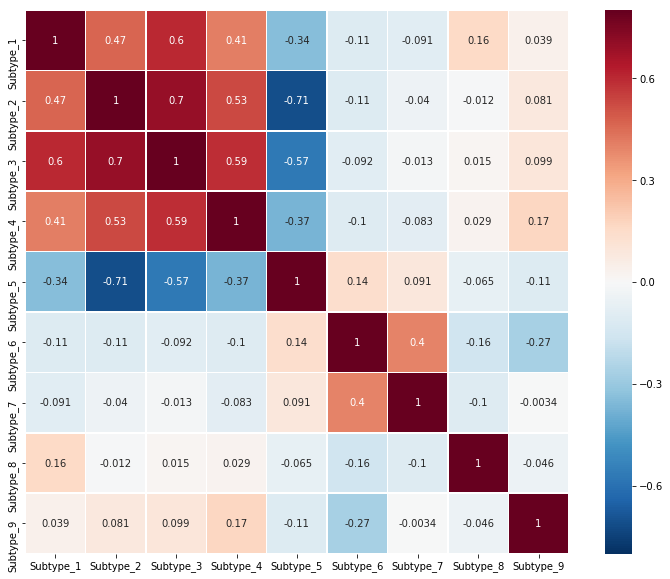

In [40]:
f, ax = plt.subplots(figsize=(n_sbt+4, n_sbt+1))
sns.heatmap(merged_pheno.get(["Subtype_{}".format(x) for x in np.arange(1,n_sbt+1)]).corr(),linewidths=.5,annot=True,ax=ax,vmax=.8,square=True)

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [47]:
# extract all table pheno value
df_stack = merged_pheno_norm.drop(['Subject'],axis=1)
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [48]:
# push varaiable to octave
%octave_push LABELS_Y n_sbt y
%octave LABELS_Y = LABELS_Y';

In [49]:
%%octave -o R
R = corr(y);

ans =  1

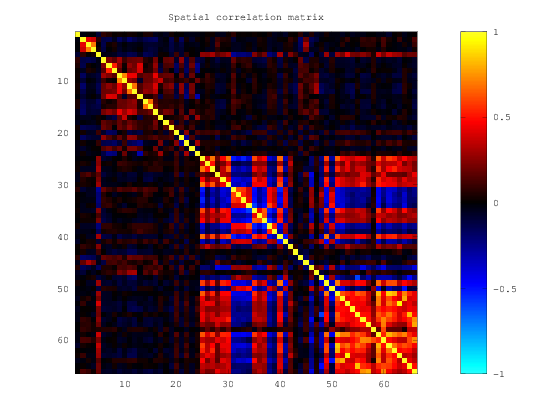

In [50]:
%%octave
niak_visu_matrix(R), axis square
title('Spatial correlation matrix')

In [51]:
%%octave -o stab,part_consensus,order_consensus
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',n_sbt)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',n_sbt)); # cut the consensus hierarchy
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

     Percentage done : 0 6 11 15 20 26 31 35 40 46 51 55 60 66 71 75 80 86 91 95 100 Done ! 

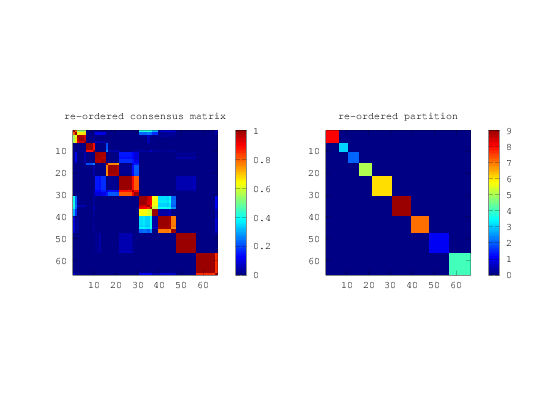

In [52]:
%%octave
order_consensus = niak_hier2order(hier_consensus);
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar
title('re-ordered consensus matrix')
subplot(1,2,2)
# Show the re-ordered partition
niak_visu_part(part_consensus(order_consensus)), axis square
title('re-ordered partition')

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


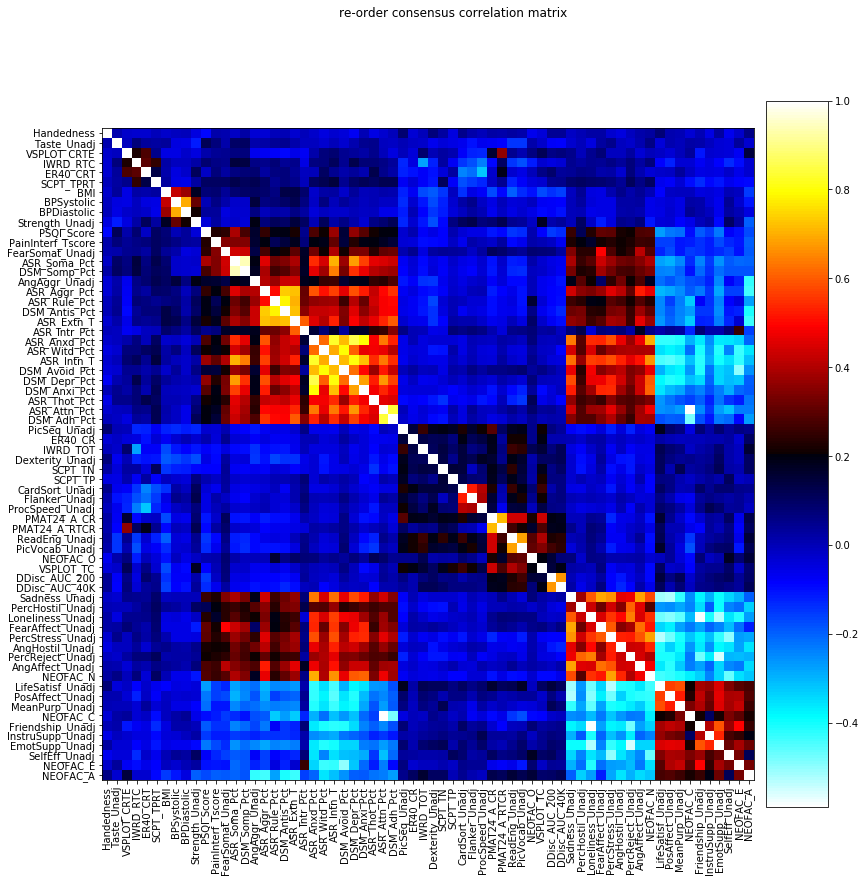

In [53]:
# Plot the distance matrix again, but now ordered by hierarchy
order_consensus_n = [int(i-1) for i in order_consensus]
label_ord = [use_columns[ordi] for ordi in order_consensus_n]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(R[order_consensus_n, :][:, order_consensus_n],cmap =nplt.cm.cold_hot)
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-order consensus correlation matrix')

In [54]:
# Here are the groups I found:
part_n = [int(i) for i in part_consensus]
for sid in np.unique(part_n):
    match_cols = [use_columns[x] for x in np.where(part_n==sid)[0]]
    print('Subtype {} has the following variables:'.format(sid))
    for col in match_cols:
        print('    {}'.format(col))

Subtype 1 has the following variables:
    Sadness_Unadj
    FearAffect_Unadj
    AngHostil_Unadj
    AngAffect_Unadj
    Loneliness_Unadj
    PercHostil_Unadj
    PercReject_Unadj
    PercStress_Unadj
    NEOFAC_N
Subtype 2 has the following variables:
    PSQI_Score
    FearSomat_Unadj
    PainInterf_Tscore
    ASR_Soma_Pct
    DSM_Somp_Pct
Subtype 3 has the following variables:
    BMI
    BPSystolic
    BPDiastolic
    Strength_Unadj
Subtype 4 has the following variables:
    LifeSatisf_Unadj
    MeanPurp_Unadj
    PosAffect_Unadj
    Friendship_Unadj
    EmotSupp_Unadj
    InstruSupp_Unadj
    SelfEff_Unadj
    NEOFAC_A
    NEOFAC_C
    NEOFAC_E
Subtype 5 has the following variables:
    AngAggr_Unadj
    ASR_Aggr_Pct
    ASR_Rule_Pct
    ASR_Intr_Pct
    ASR_Extn_T
    DSM_Antis_Pct
Subtype 6 has the following variables:
    ASR_Anxd_Pct
    ASR_Witd_Pct
    ASR_Thot_Pct
    ASR_Attn_Pct
    ASR_Intn_T
    DSM_Depr_Pct
    DSM_Anxi_Pct
    DSM_Avoid_Pct
    DSM_Adh_Pct
Subtype 7 

In [55]:
t = R[order_consensus_n, :][:, order_consensus_n]
t.shape

(66, 66)

In [56]:
n = len(part_consensus)
oci = [int(i-1) for i in order_consensus]
pco = part_consensus[oci]
bh = [pos+1 for pos, i in enumerate(np.arange(1,n)) if not pco[i]==pco[i-1]]

In [57]:
cut_here = bh
cuts = [(i, 1) for i in cut_here]
o, i, c, cuts = space_mat(t, cuts)
im = np.ma.masked_where(i==0, i)

In [58]:
rm = breakcords(cuts, o.shape)
m = make_mask(o.shape, cuts, rm, 0, None)
ticks = fix_ticks(t.shape[0], cuts, 1)

In [60]:
s9_colors = ["#beb146",
"#8f62ca",
"#61af4b",
"#c75d9c",
"#4bb092",
"#cb5253",
"#6b8bcd",
"#cb7d3e",
"#717833"]
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                          colors = s9_colors,
                                          N=9)

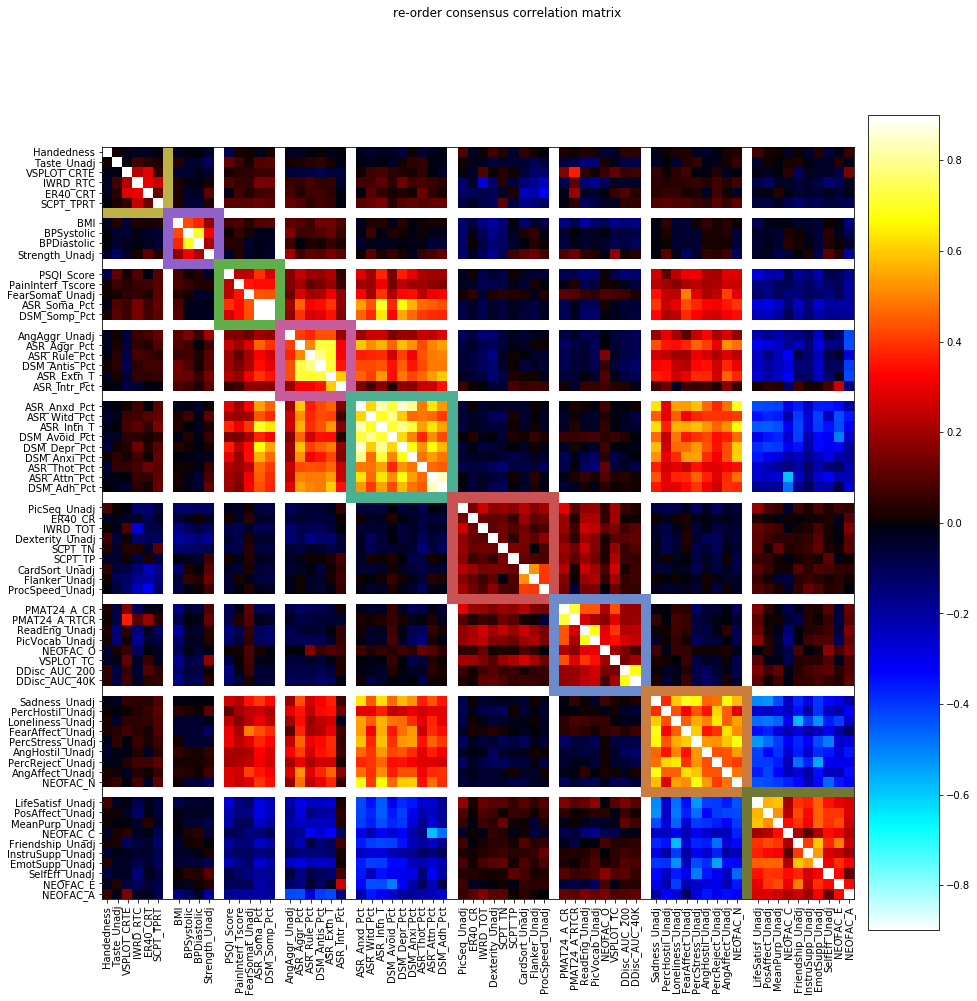

In [66]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(o, cmap=nplt.cm.cold_hot, vmin=-0.9, vmax=0.9)
tmp = ax.imshow(im, cmap=plt.cm.Greys_r)
tmp = ax.imshow(im, cmap=plt.cm.Greys, alpha=1)
tmp = ax.imshow(m, cmap=lin9)
tmp = ax.set_yticks(ticks)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ticks)
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-order consensus correlation matrix')
f.savefig('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/Figures/associations/pheno_cluster.svg')

In [222]:
# Make a new pheno table with the average scores of these bootstraped pheno
data = np.array([np.mean(merged_pheno_norm[[use_columns[x] for x in np.where(part_n==sid)[0]]],1) for sid in np.unique(part_n)])
ind = merged_pheno_norm.index
col_names = ['Subtype_{}'.format(x) for x in np.unique(part_n)]
sbt_pheno_bootstrap = pd.DataFrame(data=data.T, columns=col_names, index=ind)
merged_pheno_clust_bootstrap = pd.merge(pheno, sbt_pheno_bootstrap, how='right', left_index=True, right_index=True)

In [217]:
%%octave -o stack
# calculate the mean cluster and save it
[TAB,LABELS_X,LABELS_Y,LABELS_ID] = niak_read_csv('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv');
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:n_sbt
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end
# save clustred pheno to csv
opt.labels_y = label_y;
opt.labels_x  = LABELS_X';
opt.labels_id = 'Subject';
niak_write_csv('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_bootstraped_pheno_nonan_norm.csv',stack,opt);

Cluster 1: 

     Sadness_Unadj 

     PercReject_Unadj 

     AngAffect_Unadj 

     PercStress_Unadj 

     FearAffect_Unadj 

     AngHostil_Unadj 

     PercHostil_Unadj 

     Loneliness_Unadj 

     NEOFAC_N 

Cluster 2: 

     PSQI_Score 

     PainInterf_Tscore 

     FearSomat_Unadj 

     ASR_Soma_Pct 

     DSM_Somp_Pct 

Cluster 3: 

     BMI 

     BPSystolic 

     BPDiastolic 

     Strength_Unadj 

Cluster 4: 

     LifeSatisf_Unadj 

     MeanPurp_Unadj 

     PosAffect_Unadj 

     EmotSupp_Unadj 

     NEOFAC_E 

     Friendship_Unadj 

     InstruSupp_Unadj 

     SelfEff_Unadj 

     NEOFAC_C 

     NEOFAC_A 

Cluster 5: 

     AngAggr_Unadj 

     ASR_Aggr_Pct 

     ASR_Extn_T 

     DSM_Antis_Pct 

     ASR_Rule_Pct 

     ASR_Intr_Pct 

Cluster 6: 

     PMAT24_A_CR 

     PicVocab_Unadj 

     PMAT24_A_RTCR 

     ReadEng_Unadj 

     VSPLOT_TC 

     NEOFAC_O 

     DDisc_AUC_200 

     DDisc_AUC_40K 

Cluster 7: 

     ASR_Anxd_Pct 

     DSM_Avoid_Pct 

     DSM_Depr_Pct 

     ASR_Intn_T 

     ASR_Witd_Pct 

     DSM_Anxi_Pct 

     ASR_Thot_Pct 

     ASR_Attn_Pct 

     DSM_Adh_Pct 

Cluster 8: 

     Handedness 

     Taste_Unadj 

     VSPLOT_CRTE 

     SCPT_TPRT 

     IWRD_RTC 

     ER40_CRT 

Cluster 9: 

     PicSeq_Unadj 

     Dexterity_Unadj 

     ER40_CR 

     IWRD_TOT 

     SCPT_TN 

     SCPT_TP 

     CardSort_Unadj 

     ProcSpeed_Unadj 

     Flanker_Unadj 